# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

**Описание данных**

Данные взяты с сайта ChaLearn Looking at People. В нашем распоряжении одна папка со всеми изображениями (/final_files) и CSV-файл labels.csv с двумя колонками: file_name и real_age.

## Исследовательский анализ данных

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
import seaborn as sns
from PIL import Image

In [3]:
df = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


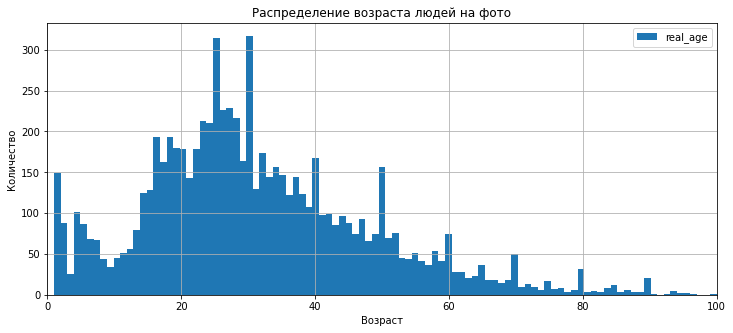

In [5]:
display(df.describe().T)
df.plot(kind='hist', bins=100, figsize=(12,5), grid=True, xlim=(0,100), title='Распределение возраста людей на фото')
plt.xlabel('Возраст')
plt.ylabel('Количество');

Датасет состоит из 7591 фотографий.

В датасете представлены фото людей от 1 до 100 лет. Средний возраст - 31.

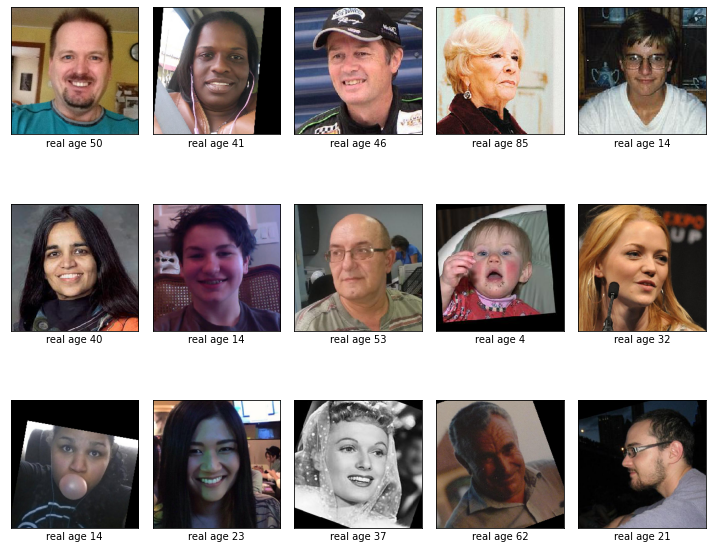

In [6]:
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(3, 5, i+1) 
    plt.imshow(train_gen_flow[0][0][i]) 
    plt.xlabel(f'real age {train_gen_flow[0][1][i]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

В датасете представлены фото различные по ракурсу, цвету, качеству. Некоторые фото повернуты или обрезаны.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


def load_train(path):
    train_datagen = ImageDataGenerator(validation_split=0.25, 
                                       rescale=1./255., 
                                       horizontal_flip=True)
    
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=pd.read_csv(path + 'labels.csv'), 
                                                     directory=(path + '/final_files'),
                                                     x_col='file_name',
                                                     y_col='real_age',
                                                     target_size=(224, 224),
                                                     batch_size=16, 
                                                     class_mode='raw',
                                                     subset='training',
                                                     seed=12345)

    return train_datagen_flow

def load_test(path):
    test_datagen = ImageDataGenerator(validation_split=0.25,
                                 rescale=1./255.)

    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=pd.read_csv(path + 'labels.csv'), 
                                                     directory=(path + '/final_files'),
                                                     x_col='file_name',
                                                     y_col='real_age',
                                                     target_size=(224, 224),
                                                     batch_size=16, 
                                                     class_mode='raw',
                                                     subset='validation',
                                                     seed=12345)


    return test_datagen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape, 
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                        include_top=False)

    model = Sequential()  
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    optimizer = Adam(lr=.0001)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

    return model 


def train_model(model, train_data, test_data, epochs=10, batch_size=None,
               steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch=len(train_data)

    if validation_steps is None:
        validation_steps=len(test_data)

    model.fit(train_data, validation_data=(test_data), epochs=epochs, verbose=2,
              batch_size=batch_size, validation_steps=validation_steps, 
              steps_per_epoch=steps_per_epoch)

    return model

```

```
Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 62s - loss: 209.1984 - mae: 10.5227 - val_loss: 299.3230 - val_mae: 12.8760
Epoch 2/10
356/356 - 54s - loss: 84.3517 - mae: 6.9336 - val_loss: 147.3636 - val_mae: 9.5257
Epoch 3/10
356/356 - 48s - loss: 58.2041 - mae: 5.8164 - val_loss: 107.3418 - val_mae: 7.9462
Epoch 4/10
356/356 - 46s - loss: 40.9746 - mae: 4.9174 - val_loss: 98.5615 - val_mae: 7.8604
Epoch 5/10
356/356 - 54s - loss: 29.7400 - mae: 4.1527 - val_loss: 77.2063 - val_mae: 6.4616
Epoch 6/10
356/356 - 71s - loss: 23.6648 - mae: 3.7139 - val_loss: 80.1925 - val_mae: 6.9456
Epoch 7/10
356/356 - 57s - loss: 21.0298 - mae: 3.4922 - val_loss: 75.0308 - val_mae: 6.5507
Epoch 8/10
356/356 - 55s - loss: 18.0710 - mae: 3.2262 - val_loss: 68.8267 - val_mae: 6.2717
Epoch 9/10
356/356 - 52s - loss: 15.8819 - mae: 3.0364 - val_loss: 65.7994 - val_mae: 6.1394
Epoch 10/10
356/356 - 51s - loss: 13.1260 - mae: 2.7610 - val_loss: 66.3666 - val_mae: 5.9846

119/119 - 10s - loss: 66.3666 - mae: 5.9846
Test MAE: 5.9846

```

## Анализ обученной модели

Модель обучена на 10 эпохах и достигла значения МАЕ = 5.9846.

Значение МАЕ достаточно разнится на обучающей и тестовой выборках: на обучающей модель ошибается в среднем на 3 года, на тестовой - на 6.

Для улучшения качества предсказания модели можно:
- увеличить количество эпох при обучении;
- избавиться от ошибок при определии лиц на фото, убрать фото с лишними предметами.